# phospho quickstart

In this quickstart, we will use the `lab` from the `phospho` package to figure out how many messages in a dataset are questions. 


1. First, we will detect events on a subset of the dataset using a pipeline powered by OpenAI GPT 3.5

2. Then, we will scale analytics with the `lab` optimizer. We will compare the event detection pipeline using MistralAI and a local Ollama model, and pick the best one in term of performance, speed and price.

3. Finally, we will use the `lab` to run the best model on the full dataset and visualize the results. 

This way, we will be able to run semantic analytics at scale on a dataset using LLMs. 

In [6]:
!pip install -q python-dotenv "phospho[lab]" 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index 0.9.6.post2 requires urllib3<2, but you have urllib3 2.2.1 which is incompatible.


In [7]:
# Load and check env variables
from dotenv import load_dotenv

load_dotenv()

from phospho import config

assert config.OPENAI_API_KEY is not None, "You need to set the OPENAI_API_KEY environment variable" 

## Setup the Event detection pipeline

In phospho, there are two important concepts:
- A workload, which is a set of jobs. Those jobs are run asynchronously and in parallel.
- A job, which is a python function that returns a JobResult. Jobs are parametrized with a JobConfig.

In this example, the Job is to detect an event ("Event Detection") using LLM self-reflection (we asked another LLM whether the event occured or not). We will try to detect the event: "The user asks a question to the assistant". 

In [8]:
from phospho import lab

# Create a workload in our lab
workload = lab.Workload()

# Add our job to the workload
workload.add_job(
    lab.Job(
        name="sync_event_detection",
        id="question_answering",
        config=lab.EventConfig(
            event_name="Question Answering",
            event_description="User asks a question to the assistant",
            model_id="openai:gpt-3.5-turbo"
        )
    )
)

Now that everything is set up, we can run the pipeline on a Message. 

We want to detect whether the user asks a question. Sometimes, it's easy: there is a question mark. But sometimes, it's not: you understand that it is a question only through context and semantics. That's why you need an LLM.

In [9]:
await workload.async_run(
    messages=[
        # This message is a question, very simple to detect. 
        lab.Message(
            id="message_1",
            content="What is the capital of France?",
        ),
        # This message is not a question, so it should not be detected.
        lab.Message(
            id="message_2",
            content="I don't like croissants.",
        ),
        # This message is also a question, but it lacks a question mark. You need semantics to detect it.
        lab.Message(
            id="message_3",
            content="I wonder what's the capital of France...",
        )
    ]
)

for i in range(1, 4):
    print(f"In message {i}, the Event question answering was detected: {workload.results['message_'+str(i)]['question_answering'].value}")


In message 1, the Event question answering was detected: True
In message 2, the Event question answering was detected: False
In message 3, the Event question answering was detected: True


# Dataset analytics

Now, let's assume we want to find user questions in a large dataset. How would we do it?

Let's load a dataset of messages from huggingface.

In [10]:
!pip install -q datasets

In [11]:
from datasets import load_dataset

dataset = load_dataset("daily_dialog")

/Users/nicolasoulianov/anaconda3/envs/phospho-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This dataset has more than 10 000 samples. That's a lot and running analytics on it can quickly become pricy. So let's just select a subsample of it.

In [12]:
dataset["train"]

Dataset({
    features: ['dialog', 'act', 'emotion'],
    num_rows: 11118
})

In [13]:
# Generate a sub dataset with 30 messages
sub_dataset = dataset["train"].select(range(30))

# Let's print one of the messages
print(sub_dataset[0]["dialog"][0])

# Build the message list for our lab
messages = []
for row in sub_dataset:
    text = row["dialog"][0]
    messages.append(lab.Message(content=text))

Say , Jim , how about going for a few beers after dinner ? 


Now, let's run the analytics pipeline on the subset. 

The workload run is asynchronous and parallelized, which means this will go much faster than just writing a for loop.

In [14]:
# Run the lab on it
# The job will be runned with the default model (openai:gpt-3.5-turbo)
workload_results = await workload.async_run(messages=messages, executor_type="parallel")

In [16]:
# Print the results
for message_id, jobs in workload_results.items():
    print(f"Message {message_id} was a question: {jobs['question_answering'].value}")

Message 583a6fe9be6d44c0a8ec08bfb5a9d2c3 was a question: False
Message fad1117dd5874e84a8684737f727bb4c was a question: True
Message ed893f49ff7248669e800efb58609239 was a question: True
Message b972a51a7a9c4dd992f259e2f63b3333 was a question: False
Message 95efb28a32a14257809aad73d31e4899 was a question: False
Message e4e7a57c06c146c49d1ec1d53add836b was a question: False
Message 4690a83bf95a44a4b676fc1cbf1c55b9 was a question: False
Message 49b839ebd5cc4652809e535f4a482754 was a question: False
Message f9ee6e9df9d1440fadbb076812a840f5 was a question: False
Message 4918792b6d7f4bd18112ccd46f9f2c75 was a question: True
Message 71eaf5f02823413cb5624b7cc39833a8 was a question: True
Message 7cb2cc2410064649978bbfb319636131 was a question: False
Message 8b1d0af4eab24f6ba121e0b85fa4591e was a question: False
Message 38ba128d9ef440e7ac4769dcd4afa182 was a question: True
Message dcc6019547104f648f3ef4aa88ab7b0f was a question: False
Message c71bcd2941b4499d94c17a4a539c03cc was a question: Fal

## Optimize the pipeline

Running semantic analytics with an LLM is great. But it's expensive and slow.

You likely want to try other model providers, such as Mistral, or even small local models. But how do they compare?

Let's run the pipeline on these models, and then figure out which one matches the reference, GPT-4. 

For the purpose of this demo, we consider a considertion good enough if it matches gpt-4 on at least 80% of the dataset. Good old Paretto.

### Installation and setup

You will need:
- a Mistral AI API key (find yours [here](https://console.mistral.ai/api-keys/))
- Ollama running on your local machine, with the Mistral 7B model installed. You can find the installation instructions for Ollama [here](https://ollama.com)

In [17]:
from phospho import config

# Check the environment variable
assert config.MISTRAL_API_KEY is not None, "You need to set the MISTRAL_API_KEY environment variable"

In [23]:
import ollama

try:
  # Let's check we can reach your local Ollama API
  response = ollama.chat(model='mistral', messages=[
    {
      'role': 'user',
      'content': 'What is the best French cheese? Keep your answer short.',
    },
  ])
  print(response['message']['content'])
except Exception as e:
  print(f"Error: {e}")
  print("You need to have a local Ollama server running to continue and the mistral model downloaded. \nRemove references to Ollama otherwise.")


Camembert


### Compute the results with the alternative configurations

To run the jobs on multiple models at the same time, we will simply set up our job with a different configuration. 

In [24]:
from typing import Literal

workload = lab.Workload()

# Setup the configs for our job
class EventConfig(lab.JobConfig):
    event_name: str
    event_description: str
    # Model are ordered from the least desired to the most desired
    # The default model is set to be the "reference"
    model_id: Literal["openai:gpt-4", "mistral:mistral-large-latest", "mistral:mistral-small-latest", "ollama:mistral-7B"] = "openai:gpt-4"

# Add our job to the workload
workload.add_job(
    lab.Job(
        name="sync_event_detection",
        id="question_answering",
        config=EventConfig(
            event_name="Question Answering",
            event_description="User asks a question to the assistant",
            model_id="openai:gpt-4"
        )
    )
)

/Users/nicolasoulianov/anaconda3/envs/phospho-env/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


We run the workload in the same way. 

In [25]:
workload_results = await workload.async_run(messages=messages, executor_type="parallel")

In [27]:
# Note the default model is currently set to "openai:gpt-4"
workload.jobs[0].config.model_id

'openai:gpt-4'

Now, let's also run the pipeline on alternative models. 

In [26]:
# Compute alternative results with the Mistral API and Ollama
await workload.async_run_on_alternative_configurations(messages=messages, executor_type="parallel")

We ask the workload to figure out which model is better. 

Note that this can actually work with any set of parameters, not just models. It's a flexible way to perform a grid search. 

In [28]:
workload.optimize_jobs(accuracy_threshold=0.8)

2024-02-29 19:24:35,159 INFO phospho.lab.lab: Found a less costly config with accuracy of 0.8. Swapping to it.


accuracies: [0.8666666666666667, 0.8, 0.6]


Let's check what model was picked. 

In [29]:
# let's check the new model_id (if it has changed)
workload.jobs[0].config.model_id

'mistral:mistral-small-latest'

Interesting! We can run our pipeline with roughly the same accuracy using a much smaller model. That's a lot of time, compute and money saved.

## Run our workload on the full dataset, with optimized parameters

Now that we have benchmarked different models for our Event detection pipeline, let's run the optimal configuration on a larger chunk of the dataset. 

In [30]:
sub_dataset = dataset["train"].select(range(200)) # Here you can just leave it as dataset["train"] if you want to use the whole dataset

# Build the message list for our lab
messages = []
for row in sub_dataset:
    text = row["dialog"][0]
    messages.append(lab.Message(content=text))

In [31]:
# The job will be runned with the best model (mistral:mistral-small-latest in our case)
workload_results = await workload.async_run(messages=messages, executor_type="parallel")

## Analyze the results

Now, we were trying to see which share of the dataset is actually a question. Let's get the results as a dataframe and visualize them.  

In [33]:
# Using .results_df() we can get a pandas dataframe with the results
workload.results_df()

,question_answering
fa4c80d52bcf46d2a39575c952d7c150,False
f5d6f30cf533452f8e931aa5fe9ff1b3,False
c2b34956edcb4c0d91315176835ea174,True
160686f19df843939764f22a4c54c0cf,False
6811f4a779d046e8b88b017d44ff5ead,False
...,...
2d5db195448644bcb02aa0ef78a3fe12,True
2603020bb7214467b93d95eb1af81e29,True
fcc314ed2941444da6639bb41f4ea9b0,True
053f18b30be04f00a6b61f161e4410b7,True


We can see that there are many questions in this dataset...

In [39]:
workload.results_df().groupby("question_answering").size()

question_answering
False    111
True      89
dtype: int64

Let's make a nice plot.

In [40]:
!pip install -q matplotlib

<Axes: xlabel='question_answering'>

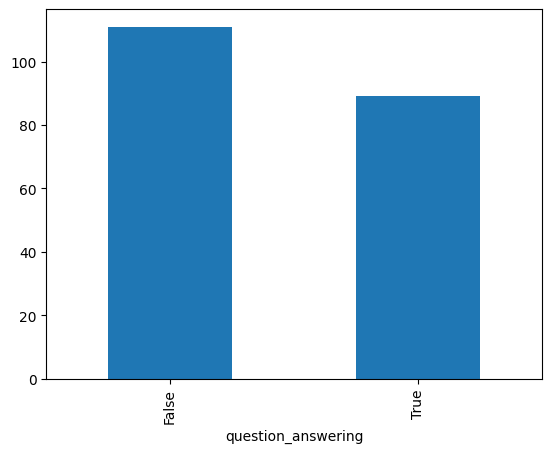

In [41]:
workload.results_df().groupby("question_answering").size().plot(kind="bar")

## Going further

You can use the `lab` to run other tasks, such as:
- Named Entity Recognition
- Sentiment Analysis
- Evaluations
- And more!

You can also play around with differnet models, different hyperparameters, and different datasets.

You want to have such analysis on your own LLM app, in real time? Check out the cloud hosted version of phospho, available on [phospho.ai](https://phospho.ai)